In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.stats.diagnostic as diag
import scipy.stats as sc
from matplotlib import pyplot
import statsmodels.formula.api as smf

## FLOW:

This study focuses on the advert dataset and aims to work on deconstructing its components and try accurately predicting values monthly sales and advertising: (From problem sets)

In [76]:
q2_temp = pd.read_csv('advert.csv')

#Rename column header and index
q2_temp.rename(columns = {'Unnamed: 0' : 'trend'}, inplace = True)

### Let's plot the advertising and sales data on a time basis to better see their relation with each other and time:

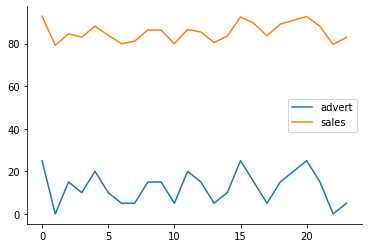

In [69]:
fig, ax = plt.subplots()
q2_temp[["advert","sales"]].plot(ax=ax)
ax.legend(loc="best")
sns.despine()
plt.show()

#### Let's construct a simple regression on the data:

In [70]:
formula="sales~advert"
mod = smf.ols(formula,data=q2_temp)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     170.0
Date:                Sun, 31 Jan 2021   Prob (F-statistic):           7.96e-12
Time:                        13:56:42   Log-Likelihood:                -42.831
No. Observations:                  24   AIC:                             89.66
Df Residuals:                      22   BIC:                             92.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     78.7343      0.597    131.806      0.0

### Let's check for the residual. We want the deviation to be random, normally distributed and no auto correlation exists: 

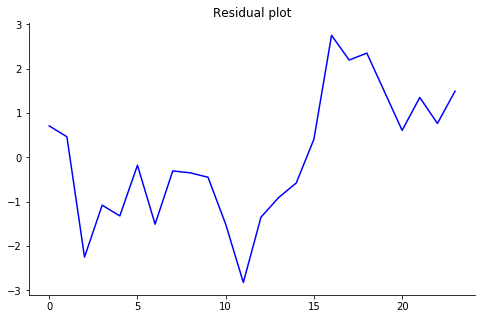

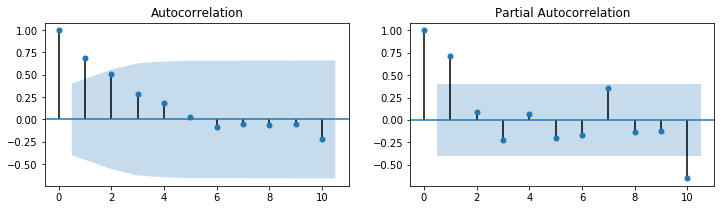

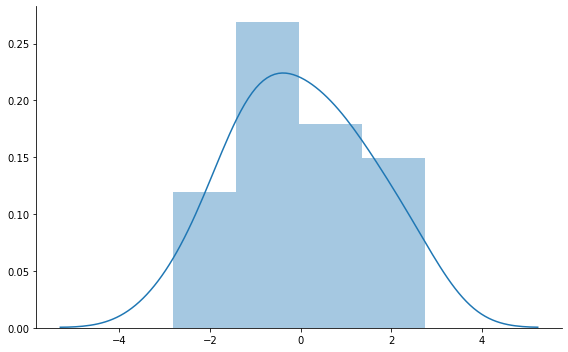

In [73]:
resid = res.resid

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color='blue')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(12,3))
sm.graphics.tsa.plot_acf(resid, lags=10, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=10, ax=ax[1])

fig, ax= plt.subplots(figsize=(8,5))
sns.distplot(resid, ax=ax)
sns.despine()

fig.tight_layout()
plt.show()

According to graphs, residuals are not white noise. We can especially see it from acf and pacf.

### Now, more appropriate to our problem, let's implement a SARIMAX() model which takes seasonality into account: 

In [78]:
arima1 = sm.tsa.SARIMAX(q2_temp['sales'], order=(0, 0, 0), seasonal_order=(0, 2, 0, 4)).fit()
arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:                   sales   No. Observations:                   24
Model:             SARIMAX(0, 2, 0, 4)   Log Likelihood                 -51.847
Date:                 Sun, 31 Jan 2021   AIC                            105.694
Time:                         14:00:30   BIC                            106.467
Sample:                              0   HQIC                           105.734
                                  - 24                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        38.2054     13.045      2.929      0.003      12.638      63.773
===================================================================================
Ljung-Box (L1) (Q):                   0.74   Jarque-Bera (JB):                 1.63
Prob(Q):                              0.39   Prob(JB):                         0.44
Heteroskedasticity (H):               3.65   Skew:                            -0.78
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Residual analysis:

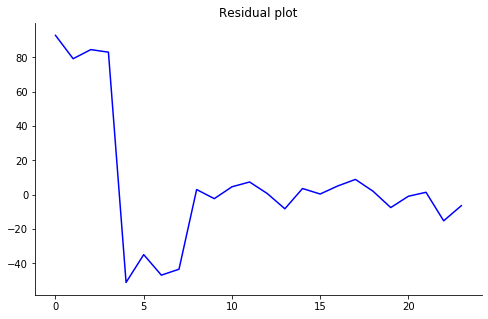

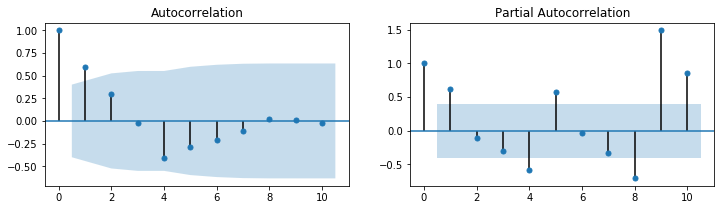

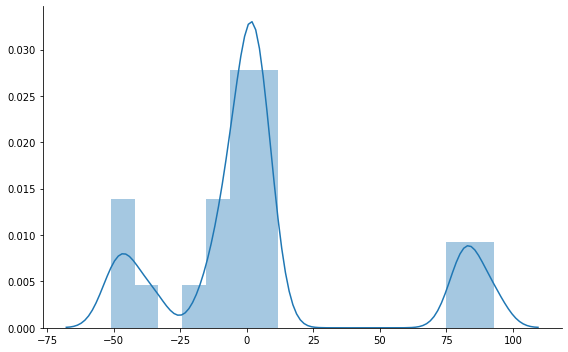

In [79]:
resid = arima1.resid

fig, ax= plt.subplots(figsize=(8,5))
resid.plot(color='blue')
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot')
sns.despine()
plt.show()

fig, ax = plt.subplots(1,2, figsize=(12,3))
sm.graphics.tsa.plot_acf(resid, lags=10, ax=ax[0])
sm.graphics.tsa.plot_pacf(resid, lags=10, ax=ax[1])

fig, ax= plt.subplots(figsize=(8,5))
sns.distplot(resid, ax=ax)
sns.despine()

fig.tight_layout()
plt.show()

Our data shows no significant upward trend but graph indicates a strong seasonality.
So, keeping ARIMA(0,0,0) parameters constant and using second order seasonal difference our timeseries analysis performs well.
However, because we are not using advert feature, there are still unexplained residual trend in our model.

### Refit by using autoarima, let the machine decide:

In [80]:
ARIMA_auto=auto_arima(q2_temp.iloc[:,2],exogenous=np.array(q2_temp.iloc[:,1]).reshape(-1,1),trend='c',seasonal=True)
ARIMA_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -34.148
Date:                Sun, 31 Jan 2021   AIC                             76.296
Time:                        14:04:17   BIC                             81.009
Sample:                             0   HQIC                            77.546
                                 - 24                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.0931     18.391      1.147      0.251     -14.953      57.139
x1             0.5079      0.024     21.476      0.000       0.462       0.554
ar.L1          0.7339      0.232      3.159      0.002       0.279       1.189
sigma2         0.9759      0.328      2.975      0.003       0.333       1.619
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.94   Prob(JB):                         0.86
Heteroskedasticity (H):               0.78   Skew:                            -0.26
Prob(H) (two-sided):                  0.73   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Selected model is SARIMAX(1, 0, 0)(0,2,0,4).

### Residuals Check:

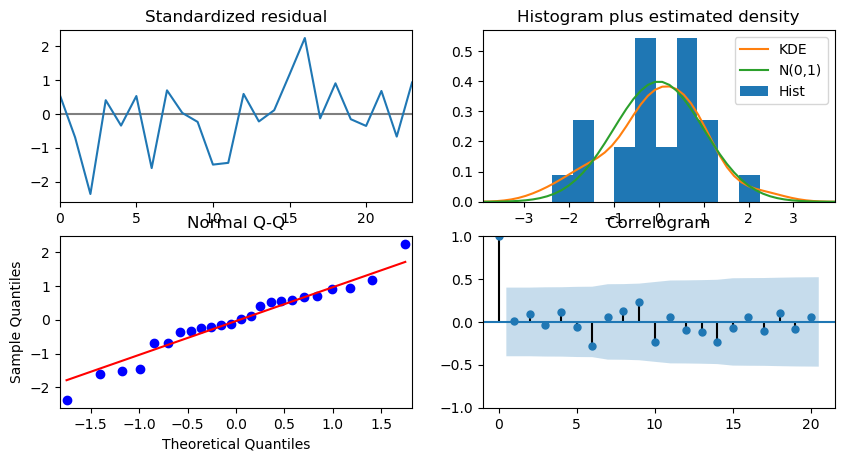

In [82]:
plot = ARIMA_auto.plot_diagnostics(lags=20,fig=plt.figure(figsize=(10,5), dpi=100))
fig.tight_layout()

Although residuals does not look like normally distributed, they look like White Noise.

### Let's assume advertising budget to be 10 for the 6 months and predict:

In [87]:
six_months_forecast = ARIMA_auto.predict(n_periods=6, exogenous = np.array((10,10,10,10,10,10)).reshape(-1,1) )
q3_temp = q2_temp.append(list(six_months_forecast), ignore_index = True)
q3_temp['Prediction'] = q3_temp[0]

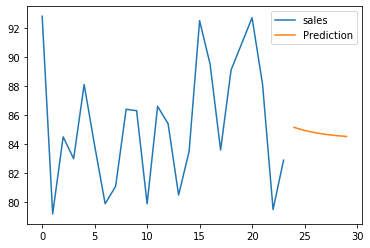

In [88]:
fig,ax=plt.subplots()
q3_temp[['sales', 'Prediction']].plot(ax=ax)

##### My additional trial with advertising budget (10,20,5,17,11,10) :

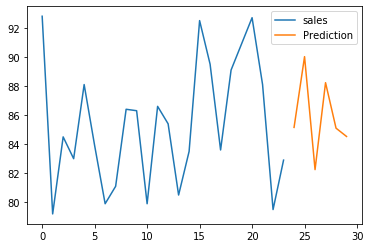

In [90]:
six_months_forecast1 = ARIMA_auto.predict(n_periods=6, exogenous = np.array((10,20,5,17,11,10)).reshape(-1,1) )
q3_temp1 = q2_temp.append(list(six_months_forecast1), ignore_index = True)
q3_temp1['Prediction'] = q3_temp1[0]

fig,ax=plt.subplots()
q3_temp1[['sales', 'Prediction']].plot(ax=ax)

##### We see that most of the prediction comes from the advertisement especially when observing my trial with different advertisements. So, with equal advertisements, prediction is flat. The strong relation between advertising and sales is obvious.